DeGAN neural network with generative extra training.

#### Loading libs

In [2]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new!
from keras import backend as K
from keras.utils.vis_utils import plot_model
# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### This code uses once per colab session to download *pydot* and *graphviz* libs

In [2]:
!pip3 install pydotplus
!pip3 install pydot
!apt-get -qq install -y graphviz && pip3 install -q pydot
!pip3 install pydot-ng
!pip3 install graphviz
!apt-get install python-pydot python-pydot-ng graphviz
import pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
python-pydot is already the newest version (1.2.3-1).
python-pydot-ng is already the newest version (1.0.0-3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


#### IN COLAB Load data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
input_images = "/content/drive/My Drive/full_numpy_bitmap_The Eiffel Tower.npy"
data = np.load(input_images)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### LOCALLY Loading data

In [0]:
input_images = "D:/full_numpy_bitmap_castle.npy"
data = np.load(input_images)

#### Some input data tests

In [4]:
data.shape #output amount of pics and dimensions

(134801, 784)

In [5]:
data[3117] #output pic 3117

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  66,  47,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   5, 236, 152,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  72, 255, 118,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 157, 255,
        77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
       236, 255,  37,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

#### Normalizing data and reshape into square pic


In [0]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]

#### Some reshaped data tests

In [7]:
data.shape #output amount of pics and dimensions

(134801, 28, 28, 1)

In [0]:
data[3117] #output pic 3117

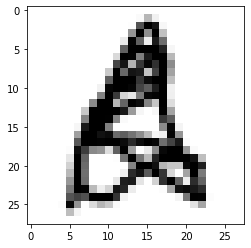

In [11]:
plt.imshow(data[3112,:,:,0], cmap='Greys') #output bitmap as a picture

#### Create network of discriminator function
*depth* - base neurons amount in hidden layer

*p* - dropout coefficient

return discriminator network model

In [0]:
def build_discriminator(depth=64, p=0.4):

    # input layer
    image = Input((img_w,img_h,1))
    
    # Hide layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)
    
    # Model construction
    model = Model(inputs=image, outputs=prediction)

    # printing summary info about discriminator
    print(model.summary())
    plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

    return model

#### Compiling discriminator model

In [10]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0   

#### Build an untrainable discriminator
Full copy of trainable discriminator, for avoiding unfixed error in Keras.

In [11]:
# Build second discriminator:
discriminator_ = build_discriminator()

# Deny training of this discriminator
discriminator_.trainable = False

# Copying actual parameters into frozen discriminator
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 256)         0   

#### Create generator network

In [0]:
z_dimensions = 32 #input noise signal dimensions amount

#### Define generator network function
*latent_dim* - input dimensions

*depth* - base neurons amount in hidden layer

*p* - dropout coefficient

return generator network model

In [0]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Inputs
    noise = Input((latent_dim,))
    
    # Input preparation and reshaping
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Deconvolutional layers with batch normalisation
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model construction
    model = Model(inputs=noise, outputs=image)

    # printing summary info about generator
    print(model.summary())
    plot_model(model, to_file='generator_model_plot1.png', show_shapes=True, show_layer_names=True)

    return model

#### Compiling generator model

In [14]:
generator = build_generator()
generator.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004,
                                            decay=3e-8,
                                            clipvalue=1.0),
                          metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0   

#### Building adversarial network function
*no parameters*

return adversarial network model

In [0]:
def build_adversarial():
          
    # Input
    z = Input(shape=(z_dimensions,))
    
    # Generate input noise vector
    img = generator(z)
    
    # Make prediction
    pred = discriminator_(img)
       
    # Build model
    model = Model(inputs=z, outputs=pred)

    # printing summary info about whole adversarial network
    print(model.summary())
    plot_model(model, to_file='adv_model_plot1.png', show_shapes=True, show_layer_names=True)

    return model

#### Build adversarial network

In [17]:
adversarial_model = build_adversarial()
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_3 (Model)              (None, 28, 28, 1)         183713    
_________________________________________________________________
model_2 (Model)              (None, 1)                 4311553   
Total params: 4,495,266
Trainable params: 177,329
Non-trainable params: 4,317,937
_________________________________________________________________
None


#### Training function
*epoch* - number of epoch

*batch* - number of pics into one training batch

*z_dim* - number of input noise signal dimensions

return adversarial network metrics, discriminator metrics

In [0]:
def train(epochs=500, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # train discriminator
        # ________________________________________
        # real pics with randomisation:
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake pics:
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate real and fake pics:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator:
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])
        
        # make training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        

        # train adversarial network
        # ________________________________________
        
        # noise input
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Copy weights to second discriminator
        copy_weights(discriminator, discriminator_)
        
        # make train
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        #     Results     #
        # ________________________________________
        
        # periodically print progress and fake images:
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

#### Start training procedure

Epoch #19
19: [D loss: 0.402041, acc: 0.000000]  [A loss: 2.272448, acc: 0.092516]


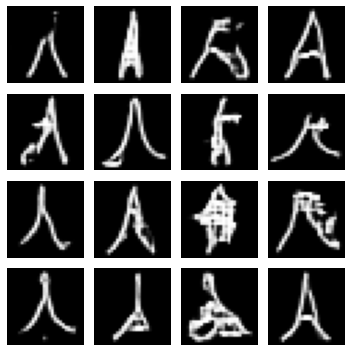

Epoch #39
39: [D loss: 0.390896, acc: 0.000000]  [A loss: 2.249464, acc: 0.078926]


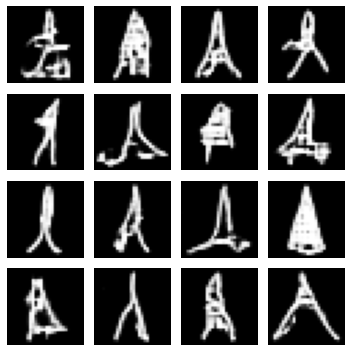

Epoch #59
59: [D loss: 0.383423, acc: 0.000000]  [A loss: 2.257068, acc: 0.079846]


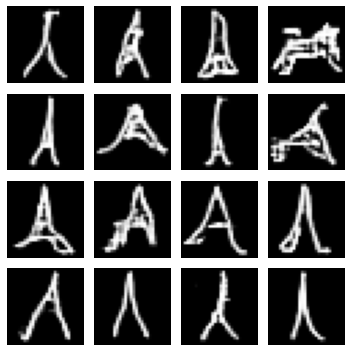

Epoch #79
79: [D loss: 0.378337, acc: 0.000000]  [A loss: 2.248381, acc: 0.079806]


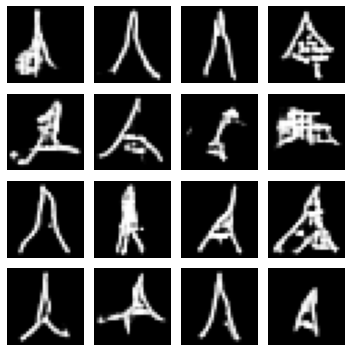

Epoch #99
99: [D loss: 0.379984, acc: 0.000000]  [A loss: 2.249208, acc: 0.078441]


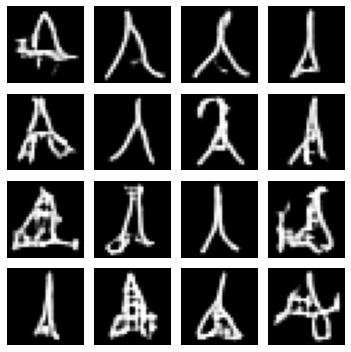

Epoch #119
119: [D loss: 0.377162, acc: 0.000000]  [A loss: 2.243732, acc: 0.076024]


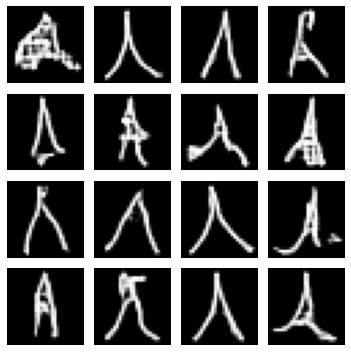

Epoch #139
139: [D loss: 0.377365, acc: 0.000000]  [A loss: 2.237653, acc: 0.075764]


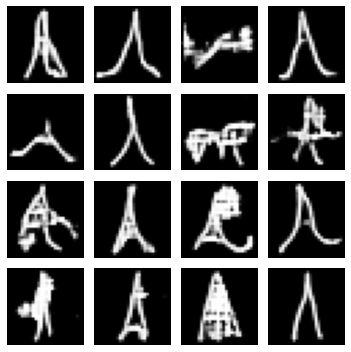

Epoch #159
159: [D loss: 0.377902, acc: 0.000000]  [A loss: 2.220082, acc: 0.077535]


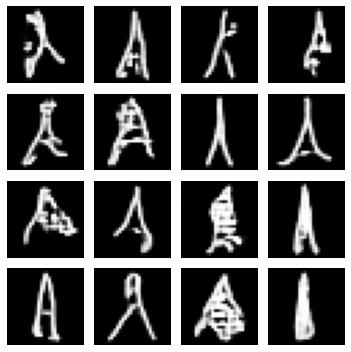

Epoch #179
179: [D loss: 0.376433, acc: 0.000000]  [A loss: 2.219818, acc: 0.076117]


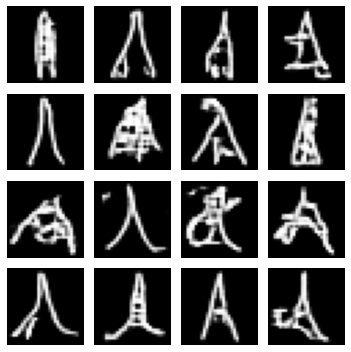

Epoch #199
199: [D loss: 0.376518, acc: 0.000000]  [A loss: 2.216442, acc: 0.075377]


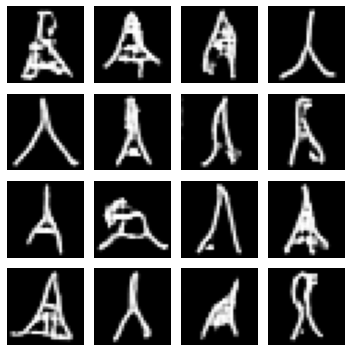

Epoch #219
219: [D loss: 0.376202, acc: 0.000000]  [A loss: 2.215111, acc: 0.074700]


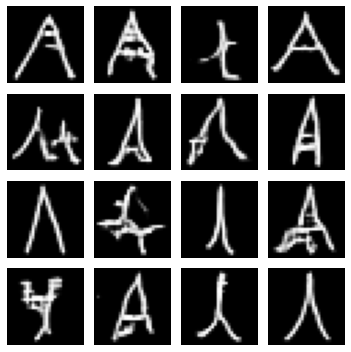

Epoch #239
239: [D loss: 0.375256, acc: 0.000000]  [A loss: 2.222432, acc: 0.074823]


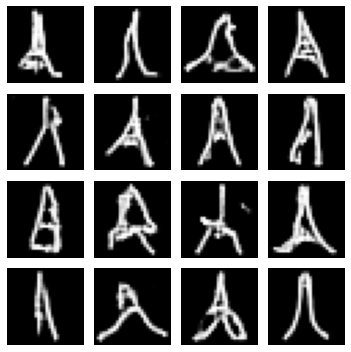

Epoch #259
259: [D loss: 0.375872, acc: 0.000000]  [A loss: 2.220640, acc: 0.075229]


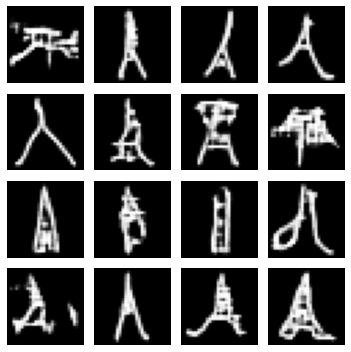

Epoch #279
279: [D loss: 0.375587, acc: 0.000000]  [A loss: 2.218975, acc: 0.074569]


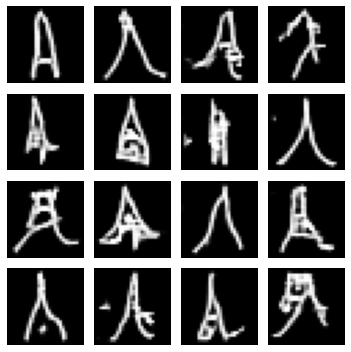

Epoch #299
299: [D loss: 0.375333, acc: 0.000000]  [A loss: 2.219106, acc: 0.074232]


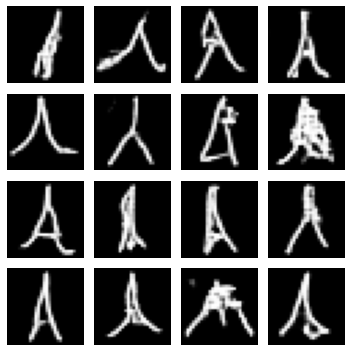

Epoch #319
319: [D loss: 0.375390, acc: 0.000000]  [A loss: 2.217208, acc: 0.074231]


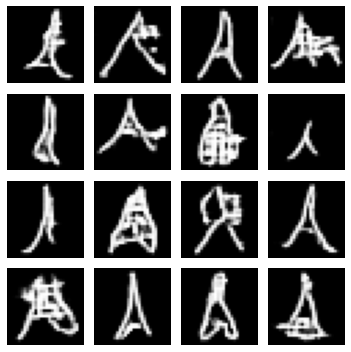

Epoch #339
339: [D loss: 0.375803, acc: 0.000000]  [A loss: 2.215133, acc: 0.074415]


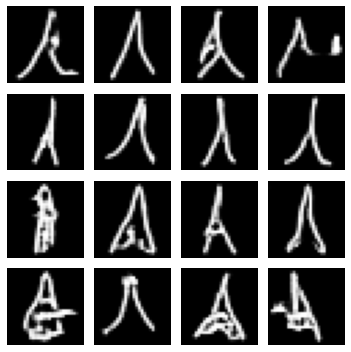

Epoch #359
359: [D loss: 0.376059, acc: 0.000000]  [A loss: 2.212138, acc: 0.074513]


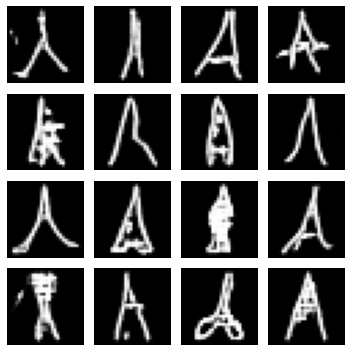

Epoch #379
379: [D loss: 0.375966, acc: 0.000000]  [A loss: 2.208904, acc: 0.074909]


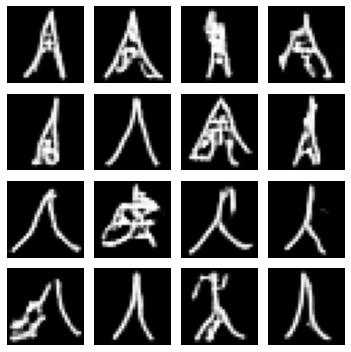

Epoch #399
399: [D loss: 0.375867, acc: 0.000000]  [A loss: 2.205628, acc: 0.074542]


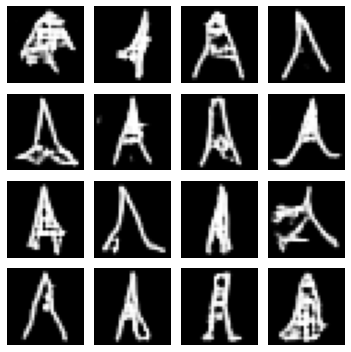

Epoch #419
419: [D loss: 0.375430, acc: 0.000000]  [A loss: 2.206129, acc: 0.074433]


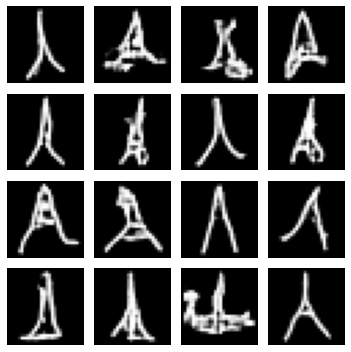

Epoch #439
439: [D loss: 0.375368, acc: 0.000000]  [A loss: 2.204097, acc: 0.074868]


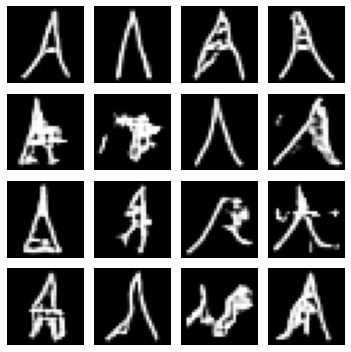

Epoch #459
459: [D loss: 0.375519, acc: 0.000000]  [A loss: 2.201193, acc: 0.074670]


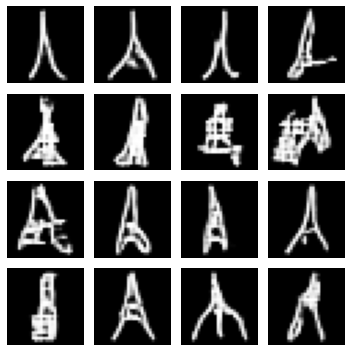

Epoch #479
479: [D loss: 0.375948, acc: 0.000000]  [A loss: 2.200162, acc: 0.074912]


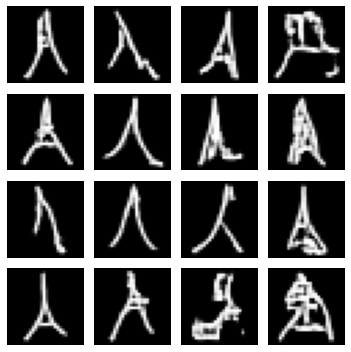

Epoch #499
499: [D loss: 0.375868, acc: 0.000000]  [A loss: 2.199793, acc: 0.074790]


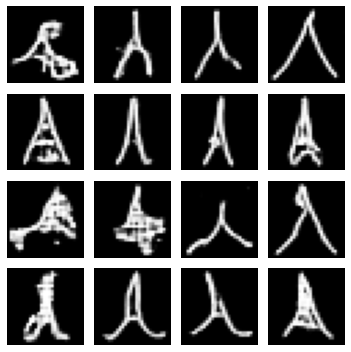

In [23]:
a_metrics_complete, d_metrics_complete = train()

#### Print Loss and Accuracy plots

Text(0, 0.5, 'Loss')

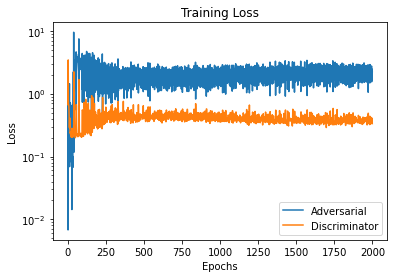

In [20]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

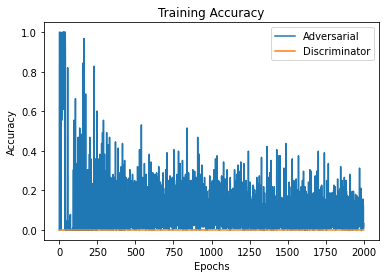

In [21]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")